In [1]:
!pip install pyspark

     |████████████████████████████████| 212.3 MB 15 kB/s 
     |████████████████████████████████| 198 kB 34.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=02aa3cbaffc231d254163421cfbe5c6dbbbe051c436ac809e0b50d2efb44fec8
  Stored in directory: /root/.cache/pip/wheels/43/47/42/bc413c760cf9d3f7b46ab7cd6590e8c47ebfd19a7386cd4a57
Successfully built pyspark


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import os

from pyspark.sql import SparkSession 
from pyspark.ml  import Pipeline     
from pyspark.sql import SQLContext  
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit

In [3]:
csv_path = r'/kaggle/input/bitcoin-tweets-20160101-to-20190329/tweets.csv'
df = pd.read_csv(csv_path, sep=';', nrows=10000)                 # just 10000 rows for a start

df['timestamp'] = pd.to_datetime(df['timestamp'])                # convert to date/time

df.head()

,id,user,fullname,url,timestamp,replies,likes,retweets,text
0,1132977055300300800,KamdemAbdiel,Abdiel kamdem,NaN,2019-05-27 11:49:14+00:00,0,0,0,È appena uscito un nuovo video! LES CRYPTOMONN...
1,1132977073402736640,bitcointe,Bitcointe,NaN,2019-05-27 11:49:18+00:00,0,0,0,Cardano: Digitize Currencies; EOS https://t.co...
2,1132977023893139456,3eyedbran,Bran - 3 Eyed Raven,NaN,2019-05-27 11:49:06+00:00,0,2,1,Another Test tweet that wasn't caught in the s...
3,1132977089089556481,DetroitCrypto,J. Scardina,NaN,2019-05-27 11:49:22+00:00,0,0,0,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...
4,1132977092340191232,mmursaleen72,Muhammad Mursaleen,NaN,2019-05-27 11:49:23+00:00,0,0,0,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...


In [4]:
from textblob import TextBlob

In [5]:
csv_path = r'/kaggle/input/bitcoin-tweets-20160101-to-20190329/tweets.csv'
df = pd.read_csv(csv_path, sep=';', nrows=10000)                 # just 10000 rows for a start

df['timestamp'] = pd.to_datetime(df['timestamp'])                # convert to date/time

df.head()

,id,user,fullname,url,timestamp,replies,likes,retweets,text
0,1132977055300300800,KamdemAbdiel,Abdiel kamdem,NaN,2019-05-27 11:49:14+00:00,0,0,0,È appena uscito un nuovo video! LES CRYPTOMONN...
1,1132977073402736640,bitcointe,Bitcointe,NaN,2019-05-27 11:49:18+00:00,0,0,0,Cardano: Digitize Currencies; EOS https://t.co...
2,1132977023893139456,3eyedbran,Bran - 3 Eyed Raven,NaN,2019-05-27 11:49:06+00:00,0,2,1,Another Test tweet that wasn't caught in the s...
3,1132977089089556481,DetroitCrypto,J. Scardina,NaN,2019-05-27 11:49:22+00:00,0,0,0,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...
4,1132977092340191232,mmursaleen72,Muhammad Mursaleen,NaN,2019-05-27 11:49:23+00:00,0,0,0,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...


In [6]:
df.shape

(10000, 9)

In [7]:
df.sort_values(by='timestamp', inplace=True)        # resort the DF based on date time (oldest=first)
df.reset_index(drop=True, inplace=True)
df.head()

,id,user,fullname,url,timestamp,replies,likes,retweets,text
0,1110302988,halfin,halfin,NaN,2009-01-11 03:33:52+00:00,790,14470,5542,Running bitcoin
1,825070546018828289,Annrhefn,Annrhefn,NaN,2017-01-27 19:58:41+00:00,19,267,155,Central Banking created Debt Serfdom. This is ...
2,906181724786352128,Crypto3TH,Crypto,NaN,2017-09-08 15:45:33+00:00,3,5,3,How China Sinks Bitcoin - Probably what happen...
3,935411301056069633,real_vijay,Vijay Boyapati,NaN,2017-11-28 07:33:27+00:00,12,509,238,1/ While there are no a priori rules about the...
4,961666624880365568,CryptoGamer_,CryptoGamer,NaN,2018-02-08 18:22:44+00:00,23,135,51,"When things are down, remember it's never as b..."


In [8]:
tweets = df['text']    # the 'text' column, containing the tweets
def calc_sentiment(txt):
    blob = TextBlob(txt)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

tweets_sentiments = tweets.apply(calc_sentiment)               # calc sentiment polarity & subjectivity, return in a Series of tuples
tweets_polarity = tweets_sentiments.apply(lambda x: x[0])      # new column of polarity
tweets_subjectivity = tweets_sentiments.apply(lambda x: x[1])  # new column of subjectivity

df['polarity'], df['subjectivity'] = tweets_polarity, tweets_subjectivity  # create the series

df.sample(10)        # display 10 random rows

,id,user,fullname,url,timestamp,replies,likes,retweets,text,polarity,subjectivity
8238,1132889088871129089,amtvmedia,Christopher Greene,NaN,2019-05-27 05:59:41+00:00,13,34,3,Remember everyone that has told you not to tou...,0.500000,0.350000
9598,1132981169606340608,blec2021,blec2021,NaN,2019-05-27 12:05:35+00:00,0,0,0,@Quark_Chain #Blockchain #BTC #ETH #blockchain...,0.000000,0.000000
9270,1132980268455878657,DeribitRekt,DeribitRekt,NaN,2019-05-27 12:02:00+00:00,0,0,0,⏰ LIQUIDATION on BTC-PERPETUAL ☠️️\n\n Bought ...,0.000000,0.000000
5404,1126839432479432704,cryptofinancing,Crypto/blockchain funding,NaN,2019-05-10 11:20:31+00:00,0,0,0,"RT coindesk ""RT La__Cuen: This week I’m focusi...",0.400000,0.750000
7118,1126837888937807873,Orbital_Lexicon,Liberty.Crypto.,NaN,2019-05-10 13:28:23+00:00,1,6,2,"1st winner - ""I've got more money than your co...",0.250000,0.233333
2358,1126826927266902017,Kaissia86,Kaissia,NaN,2019-05-10 10:30:49+00:00,0,0,0,https://t.co/Ur6HGdwicC is for #sale! #domain ...,0.000000,0.000000
587,1126819276013355008,bitcoinembassya,Bitcoin Embassy NL,NaN,2019-05-10 10:00:25+00:00,0,0,0,"RT BlockchainTalkz ""#DutchBlockchainWeek\n\nTh...",0.266667,0.300000
7875,1125395194592071681,pikciochainpkc,Pikcio,NaN,2019-05-11 20:17:02+00:00,19,58,30,We have lift off! Pikcio has just launched the...,0.000000,0.000000
8288,1132915189903269888,OneHanSolo,Han Solo 💥🚀🌝,NaN,2019-05-27 07:43:24+00:00,2,66,24,China's Bitcoin Dominance Is Worrying Trump's ...,0.487500,0.612500
6083,1126842504320565249,blockchain_site,BlockchainNewsSite,NaN,2019-05-10 11:32:43+00:00,0,0,0,Crypto Markets Hit New 2019 Top as Bitcoin Cra...,0.295455,0.484848


<AxesSubplot:>

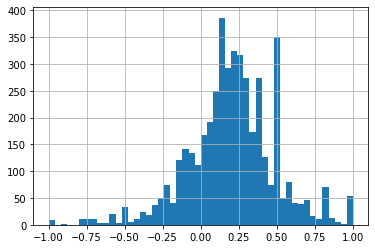

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
df.polarity.loc[df.polarity != 0.0].hist(bins=50)   # histogram of polarity (excluding those with neutral sentiment)

In [10]:
non_neutral_df = df.loc[df.polarity != 0.0]
non_neutral_df.reset_index(drop=True, inplace=True)
non_neutral_df.head().text.iloc[0]

'How China Sinks Bitcoin - Probably what happened today lol  https://t.co/eE1ez3uwQ6'

In [11]:
random_tweets = df.text.sample(100)
random_tweets.to_csv('./random_tweets.csv')
random_tweets

1617    Trump Insult of Alexandria Ocasio-Cortez Feels...
1918    Thank you @sysmannet. Hard times make strong m...
4808    New post: Bitcoin Is Back, but Should You Real...
9141    Current Crypto Prices! \n\nBTC: $8727.21 USD\n...
8382    ATR indikatörüne göre BTC (aşağı veya yukarı y...
                              ...                        
3588    Binance CEO Reveals New Details of 'Damaging' ...
7394    @LDeameliano @Xentagz Bitcoin maximalism is th...
7421    Bravo to the BTC holders making gains but let ...
1482    NEO is now £6.73. #crypto #cryptocurrency #bit...
7615                                 Gearing up for STOs!
Name: text, Length: 100, dtype: object

@Hakan00507 gecenlerde altcoınler fırladı gel gel yaptılar sımdı btc gel gel yapıyorlar sonra buraya gelıcekler mi acaba :D
--------------------------------------------------
Find the best Cryptocurrency and Bitcoin Affiliate Programs on Forex Directory! #CryptocurrencyAffiliatePrograms #CryptocurrencyAffiliateMarketing #BitcoinAffiliatePrograms #BitcoinAffiliateMarketing #ForexDirectory https://t.co/vLTo16I7El
--------------------------------------------------
@kevinolearytv $BTC bear.. !! mr. wonderful @APompliano 😅
--------------------------------------------------
@Quark_Chain #QuarkChain #QKC #Blockchain #BTC #ETH #blockchaintechnology #sharding

QuarkChain - лучшее инвестиционное решение 2019 года!
QuarkChain is the best investment solution of 2019!
--------------------------------------------------
@BradSherman When you come at the King, you best not miss. ⚡️⚡️ this isn't gonna end well for you ₿rad $BTC
--------------------------------------------------
#asus strix x99 manual h

8014    None
47      None
85      None
0       None
8015    None
8020    None
270     None
7684    None
29      None
8033    None
Name: text, dtype: object

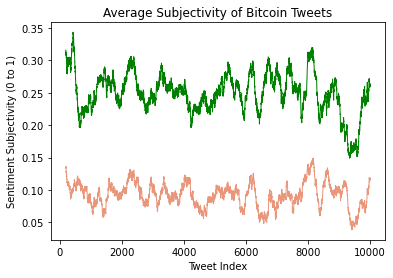

In [12]:
df.polarity.rolling(window=200).mean().plot(color='darksalmon', linewidth=1)
plt.title('Average Sentiment of Bitcoin Tweets')
plt.xlabel('Tweet Index')
plt.ylabel('Sentiment Polarity (-1 to 1)');
df.subjectivity.rolling(window=200).mean().plot(color='green', linewidth=1)
plt.title('Average Subjectivity of Bitcoin Tweets')
plt.xlabel('Tweet Index')
plt.ylabel('Sentiment Subjectivity (0 to 1)');
# 10 most positive tweets
most_positive = df.sort_values(by='polarity', ascending=False)['text'].head(10)
for i in range(len(most_positive)):
    print(most_positive.iloc[i])
    print('-' * 50)
# 10 most negative tweets
most_negative = df.sort_values(by='polarity', ascending=True)['text'].head(10)
for i in range(len(most_negative)):
    print(most_negative.iloc[i])
    print('-' * 50)
# 10 most liked tweets
most_like_tweets = df.sort_values(by='likes', ascending=False).head(10)
most_like_tweets['text'].apply(lambda x: print(x + '\n' + '-'*50))
# 10 most replied tweets
most_replied_tweets = df.sort_values(by='replies', ascending=False).head(10)
most_replied_tweets['text'].apply(lambda x: print(x + '\n' + '-'*50))